# Phase 5: Data Enrichment via API Integration

## Currency Conversion Analysis for 'Unique Gifts Ltd.'

This notebook implements Phase 5 of the 'Unique Gifts Ltd.' data analysis project, focusing on enriching our transactional data with currency conversion capabilities. We will integrate with a currency exchange API to convert our top transactions from GBP to USD and EUR.

### Learning Objectives:
- Understand API integration using Python's `requests` library
- Learn to handle API responses and errors gracefully
- Apply real-time data enrichment to existing datasets
- Create reusable functions for data transformation

### Business Context:
As Unique Gifts Ltd. expands internationally, understanding transaction values in multiple currencies becomes crucial for:
- International pricing strategies
- Cross-border financial analysis
- Global market comparison
- Investment decision-making

## 1. Import Required Libraries

We'll start by importing the necessary libraries for this phase of analysis.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Libraries for API integration
import requests
import json
import time
from datetime import datetime

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Standard libraries (system operations and warning handling)
import warnings

warnings.filterwarnings('ignore')

#
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print('All required libraries have been imported.')
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Requests version:', requests.__version__)
print('Matplotlib version:', plt.matplotlib.__version__)
print('Seaborn version:', sns.__version__)

All required libraries have been imported.
Pandas version: 2.3.1
Numpy version: 2.3.2
Requests version: 2.32.4
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


## 2. Load Cleaned Dataset

We'll load the cleaned dataset that should have been prepared in the previous phases. This assumes that data cleaning, preprocessing, and basic analysis have already been completed.

In [2]:
# Load the cleaned dataset from a CSV file
try:
    df_clean = pd.read_csv('../data/online_retail_clean.csv')
    print('Cleaned data file loaded successfully.')

    # Display basic information about the Dataset
    print()
    print("Dataset Overview:")
    print(f"    - Shape: {df_clean.shape}")
    print(f"    - Columns: {list(df_clean.columns)}")
    print(f"    - Date Range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

except FileNotFoundError:
    print('Cleaned Data File Not Found. Please ensure file exists or path is correct.')

Cleaned data file loaded successfully.

Dataset Overview:
    - Shape: (13, 13)
    - Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'TotalPrice', 'Year', 'Month', 'DayOfWeek', 'HourOfDay']
    - Date Range: 2009-12-01 07:45:00 to 2009-12-01 09:06:00


## 3. Identify the Top 100 Transactions

We'll identify the top 100 transactions by TotalPrice value, as specified in the project requirements. These high-value transactions are most important for currency conversion analysis.

In [3]:
# Ensure 'TotalPrice' column exists in the DataFrame

if 'TotalPrice' not in df_clean.columns:
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']
    print('TotalPrice column created.')

top_100_transactions = df_clean.nlargest(100, 'TotalPrice').copy()

print("Top 100 Transactions Analysis:")
print(f"   - Highest transaction value: £{top_100_transactions['TotalPrice'].max():.2f}")
print(f"   - Lowest transaction value in top 100: £{top_100_transactions['TotalPrice'].min():.2f}")
print(f"   - Average transaction value: £{top_100_transactions['TotalPrice'].mean():.2f}")
print(f"   - Total value of top 100: £{top_100_transactions['TotalPrice'].sum():.2f}")

Top 100 Transactions Analysis:
   - Highest transaction value: £100.80
   - Lowest transaction value in top 100: £30.00
   - Average transaction value: £54.66
   - Total value of top 100: £710.60


## 4. Currency Conversion API Integration

### 4.1 API Configuration and Helper Functions

We'll use 'ExchangeRate-API', a free currency conversion service. This section includes:
- API configuration
- Error handling functions
- Rate limiting to respect API limits

In [4]:
# API Configuration

API_BASE_URL = 'https://v6.exchangerate-api.com/v6/679cea4bfe60efe64fe59613/latest/'
BASE_CURRENCY = 'GBP'
TARGET_CURRENCIES = ['USD', 'EUR']

def fetch_exchange_rates(base_currency='GBP', retries=3, delay=1):
    url = f"{API_BASE_URL}{base_currency}"

    for attempt in range(retries):
        try:
            print(f"Fetching exchange rates (attempt {attempt + 1}/{retries})...")

            response = requests.get(url)
            response.raise_for_status()

            data = response.json()

            # Validate response structure
            if 'rates' in data and 'date' in data:
                print(f"Successfully fetched rates for {data['data']}")
                return data
            else:
                print("Unexpected API response format.")
                return None

        except requests.exceptions.RequestException as e:
            print(f"API request failed (attempt {attempt + 1}): {str(e)}")

            if attempt < retries - 1:
                print(f"Waiting {delay} seconds before retrying...")
                time.sleep(delay)
            else:
                print("Max retries exceeded. Exiting...")
                return None

        except json.JSONDecodeError as e:
            print(f"JSON decode error: {str(e)}")
            return None

    return None

def convert_currency(amount, from_currency, to_currency, exchange_rates):
    try:
        if from_currency == to_currency:
            return amount

        if to_currency in exchange_rates['rates']:
            converted_amount = amount * exchange_rates['rates'][to_currency]
            return round(converted_amount, 2)
        else:
            print(f"Exchange rate for {to_currency} not found in the API response.")
            return None

    except (KeyError, TypeError, ValueError) as e:
        print(f"Currency conversion error: {str(e)}")
        return None

### 4.2 Fetch Current Exchange Rates

Let's fetch the current exchange rates from the API. We'll implement proper error handling to ensure our analysis can continue even if the API is temporarily unavailable.

In [5]:
# Fetch current exchange rates
exchange_data = fetch_exchange_rates(BASE_CURRENCY)

if exchange_data:
    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Exchange rates fetched on {rate_date}.")
    print(f"Base currency: {BASE_CURRENCY}")

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            print(f"Exchange rate for {currency}: {rates[currency]}")
        else:
            print(f"Exchange rate for {currency} not found in the API response.")

else:
    print("Failed to fetch exchange rates. Please check your API configuration or network connection.")

    # Fallback rates (approximate values)
    exchange_data = {
        'date': datetime.now().strftime('%Y-%m-%d'),
        'base': BASE_CURRENCY,
        'rates': {
            'USD': 1.25,
            'EUR': 1.15
        }
    }

    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Using fallback exchange rates for {rate_date}.")

    for currency in TARGET_CURRENCIES:
        print(f"Fallback exchange rate for {currency}: {rates[currency]}")

Fetching exchange rates (attempt 1/3)...
Unexpected API response format.
Failed to fetch exchange rates. Please check your API configuration or network connection.
Using fallback exchange rates for 2025-08-20.
Fallback exchange rate for USD: 1.25
Fallback exchange rate for EUR: 1.15


## 5. Apply Currency Conversion to Top 100 Transactions

Now we'll apply the currency conversion to our top 100 transactions, creating new columns for USD and EUR values.

In [6]:
# Create a copy of the top 100 transactions for currency conversion
top_100_with_currency = top_100_transactions.copy()

# Add exchange rate information
top_100_with_currency['ExchangeRateDate'] = rate_date
top_100_with_currency['GBP_to_USD_Rate'] = rates.get('USD', None)
top_100_with_currency['GBP_to_EUR_Rate'] = rates.get('EUR', None)

# Convert TotalPrice to USD and EUR
print(f"Converting transaction values to multiple currencies...")

# USD Conversion
if 'USD' in rates:
    top_100_with_currency['TotalPrice_USD'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'USD', exchange_data)
    )
    print(f"Successfully converted TotalPrice to USD.")

else:
    top_100_with_currency['TotalPrice_USD'] = None
    print("Exchange rate for USD not found in the API response.")

# EUR Conversion
if 'EUR' in rates:
    top_100_with_currency['TotalPrice_EUR'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'EUR', exchange_data)
    )
    print(f"Successfully converted TotalPrice to EUR.")

else:
    top_100_with_currency['TotalPrice_EUR'] = None
    print("Exchange rate for EUR not found in the API response.")

# Display conversion summary
print(f"Currency Conversion Summary:")
print(f"    - Original GBP total: £{top_100_with_currency['TotalPrice'].sum():.2f}")

if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_total = top_100_with_currency['TotalPrice_USD'].sum()
    print(f"    - Converted USD total: ${usd_total:.2f}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_total = top_100_with_currency['TotalPrice_EUR'].sum()
    print(f"    - Converted EUR total: €{eur_total:.2f}")

Converting transaction values to multiple currencies...
Successfully converted TotalPrice to USD.
Successfully converted TotalPrice to EUR.
Currency Conversion Summary:
    - Original GBP total: £710.60
    - Converted USD total: $888.26
    - Converted EUR total: €817.18


## 6. Data Validation and Quality Checks

It's important to validate our currency conversion results to ensure accuracy and identify any potential issues.

In [7]:
# Check for any conversion failures
usd_failures = top_100_with_currency['TotalPrice_USD'].isna().sum()
eur_failures = top_100_with_currency['TotalPrice_EUR'].isna().sum()
total_transactions = len(top_100_with_currency)

print(f"Convertion Quality Report:")
print(f"    - Total transactional processed: {total_transactions}")
print(f"    - USD conversion failures: {usd_failures}")
print(f"    - EUR conversion failures: {eur_failures}")
print(f"    - Success rate: {(total_transactions - usd_failures - eur_failures) / total_transactions * 100:.2f}%")

# Check if any values that might indicate errors
if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_values = top_100_with_currency['TotalPrice_USD'].dropna()
    usd_mean = usd_values.mean()
    usd_std = usd_values.std()
    outliers_usd = usd_values[(usd_values > usd_mean + 3 * usd_std) | (usd_values < usd_mean - 3 * usd_std)]
    print(f"    - USD outliers found: {len(outliers_usd)}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_values = top_100_with_currency['TotalPrice_EUR'].dropna()
    eur_mean = eur_values.mean()
    eur_std = eur_values.std()
    outliers_eur = eur_values[(eur_values > eur_mean + 3 * eur_std) | (eur_values < eur_mean - 3 * eur_std)]
    print(f"    - EUR outliers found: {len(outliers_eur)}")

print()
print("Data validation completed")

Convertion Quality Report:
    - Total transactional processed: 13
    - USD conversion failures: 0
    - EUR conversion failures: 0
    - Success rate: 100.00%
    - USD outliers found: 0
    - EUR outliers found: 0

Data validation completed


## 7. Display Results and Analysis

Let's examine our currency-converted data and display the results in a meaningful way.

In [8]:
# Display the top 10 transactions for demonstration purposes
print("Top 10 Transactions with Currency Conversion:")
print("=" * 50)

display_columns = ['Invoice', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']

if 'Country' in top_100_with_currency.columns:
    display_columns.insert(1, 'Country')

if 'InvoiceDate' in top_100_with_currency.columns:
    display_columns.insert(1, 'InvoiceDate')

# Select the top 10 transactions
top_10_display = top_100_with_currency[display_columns].head(10).copy()

# Format the currency columns for better readability
if 'TotalPrice' in top_10_display.columns:
    top_10_display['TotalPrice_GBP'] = top_10_display['TotalPrice'].apply(lambda x: f"£{x:.2f}")

if 'TotalPrice_USD' in top_10_display.columns:
    top_10_display['TotalPrice_USD_formatted'] = top_10_display['TotalPrice_USD'].apply(lambda x: f"${x:.2f}" if pd.notna(x) else "N/A")

if 'TotalPrice_EUR' in top_10_display.columns:
    top_10_display['TotalPrice_EUR_formatted'] = top_10_display['TotalPrice_EUR'].apply(lambda x: f"€{x:.2f}" if pd.notna(x) else "N/A")

# Display formatted results
print(top_10_display[['Invoice', 'TotalPrice_GBP', 'TotalPrice_USD_formatted', 'TotalPrice_EUR_formatted']].to_string(index=False))

Top 10 Transactions with Currency Conversion:
 Invoice TotalPrice_GBP TotalPrice_USD_formatted TotalPrice_EUR_formatted
  489434        £100.80                  $126.00                  €115.92
  489434         £83.40                  $104.25                   €95.91
  489434         £81.00                  $101.25                   €93.15
  489434         £81.00                  $101.25                   €93.15
  489434         £59.50                   $74.38                   €68.42
  489436         £59.50                   $74.38                   €68.42
  489435         £45.00                   $56.25                   €51.75
  489435         £39.60                   $49.50                   €45.54
  489434         £39.60                   $49.50                   €45.54
  489435         £30.60                   $38.25                   €35.19


## 8. Statistical Summary and Comparison

Let's generate comprehensive statistics comparing the values across different currencies.

In [9]:
# Generate summary statistics
print("Statistical Summary Across Currencies:")
print("=" * 50)

# Calculate statistics for each currency
currencies = ['GBP', 'USD', 'EUR']
currency_columns = ['TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']
currency_symbols = ['£', '$', '€']

stats_summary = {}

for currency, column, symbol in zip(currencies, currency_columns, currency_symbols):
    if column in top_100_with_currency.columns:
        values = top_100_with_currency[column].dropna()

        if not values.empty:
            stats_summary[currency] = {
                'count': len(values),
                'mean': values.mean(),
                'median': values.median(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
                'total': values.sum(),
                'symbol': symbol
            }

# Display formatted table
if stats_summary:
    print(f"{'Metric':<10} {'GBP':<15} {'USD':<15} {'EUR':<15}")
    print("-" * 55)

    metrics = ['count', 'mean', 'median', 'std', 'min', 'max', 'total']
    metric_names = ['Count', 'Mean', 'Median', 'Std Dev', 'Minimum', 'Maximum', 'Total']

    for metric, name in zip(metrics, metric_names):
        row = f"{name:<10}"

        for currency in currencies:
            if currency in stats_summary:
                if metric == 'count':
                    value = f"{stats_summary[currency][metric]}"
                else:
                    symbol = stats_summary[currency]['symbol']
                    value = f"{symbol}{stats_summary[currency][metric]:,.2f}"

                row += f" {value:<15}"

            else:
                row += f" {'N/A':<15}"

        print(row)

Statistical Summary Across Currencies:
Metric     GBP             USD             EUR            
-------------------------------------------------------
Count      13              13              13             
Mean       £54.66          $68.33          €62.86         
Median     £45.00          $56.25          €51.75         
Std Dev    £24.68          $30.85          €28.38         
Minimum    £30.00          $37.50          €34.50         
Maximum    £100.80         $126.00         €115.92        
Total      £710.60         $888.26         €817.18        


## 9. Visualization of Currency Conversions

Create visualizations to better understand the currency conversion results.

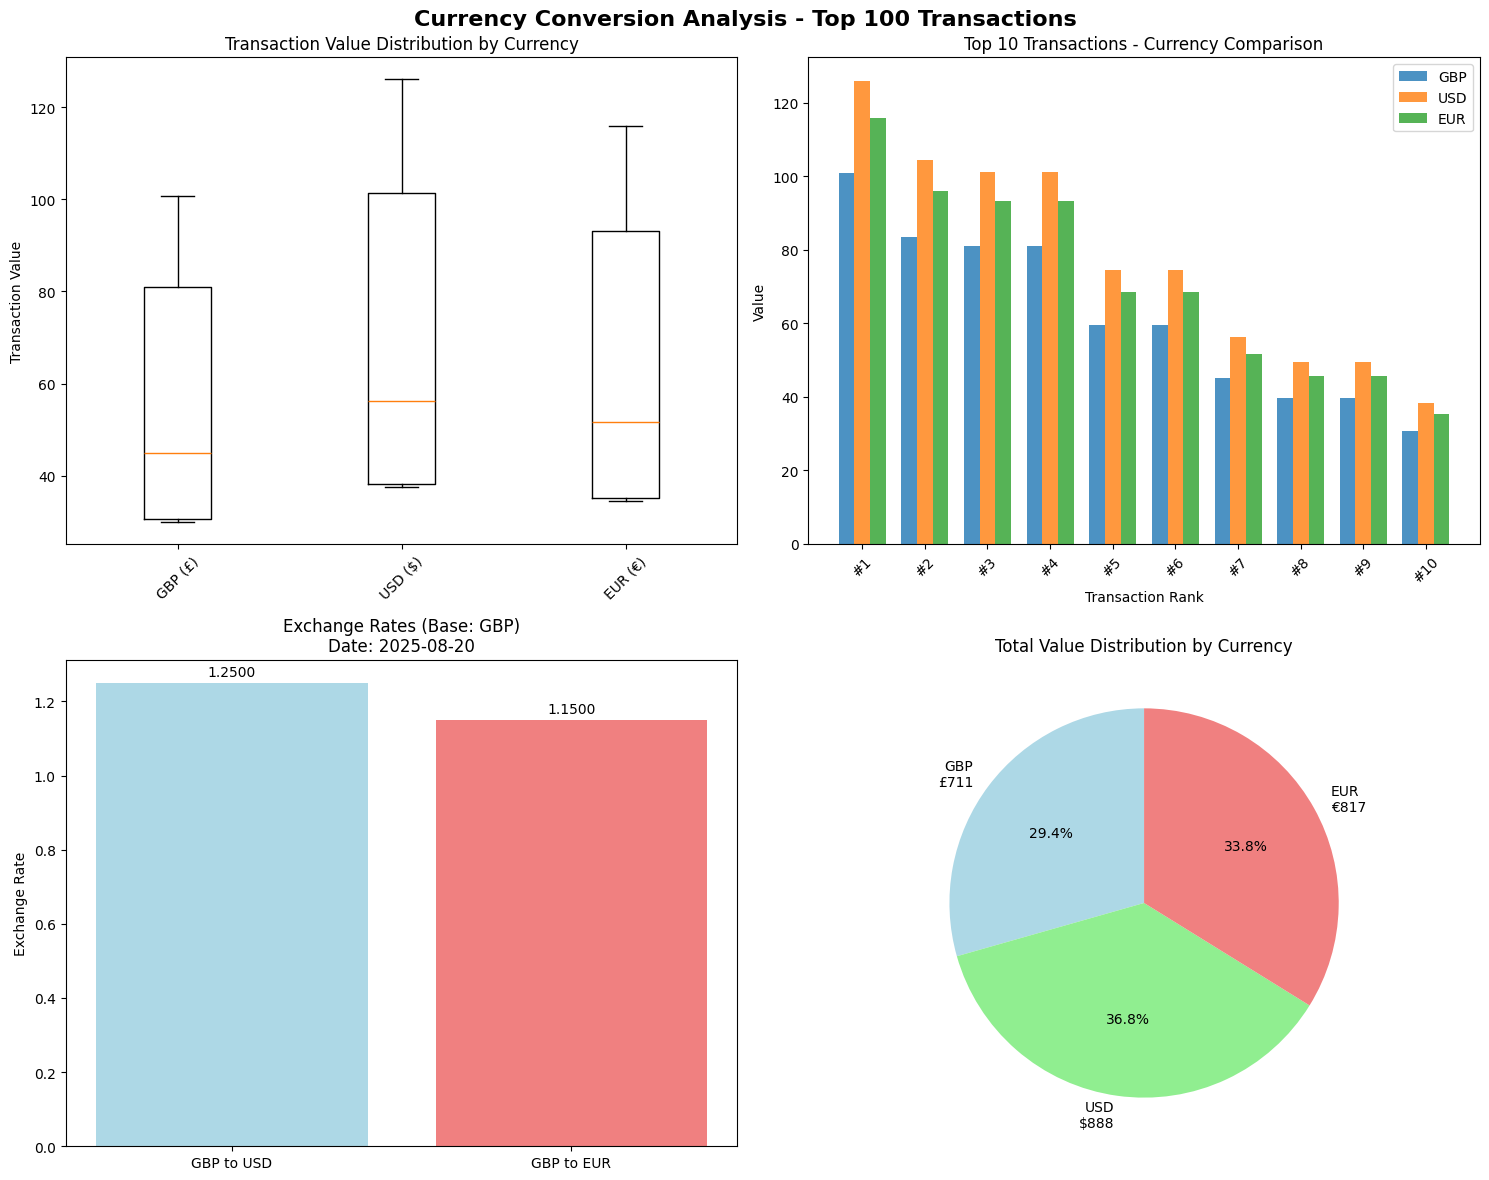

In [10]:
# Create visualizations for currency comparison
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Currency Conversion Analysis - Top 100 Transactions', fontsize=16, fontweight='bold')

# 1. Compare of transaction values across currencies
ax1 = axes[0, 0]
currency_data = []
currency_labels = []

if 'TotalPrice' in top_100_with_currency.columns:
    currency_data.append(top_100_with_currency['TotalPrice'].dropna())
    currency_labels.append('GBP (£)')

if 'TotalPrice_USD' in top_100_with_currency.columns:
    usd_data = top_100_with_currency['TotalPrice_USD'].dropna()

    if not usd_data.empty:
        currency_data.append(usd_data)
        currency_labels.append('USD ($)')

if 'TotalPrice_EUR' in top_100_with_currency.columns:
    eur_data = top_100_with_currency['TotalPrice_EUR'].dropna()

    if not eur_data.empty:
        currency_data.append(eur_data)
        currency_labels.append('EUR (€)')

if currency_data:
    ax1.boxplot(currency_data, labels=currency_labels)
    ax1.set_title('Transaction Value Distribution by Currency')
    ax1.set_ylabel('Transaction Value')
    ax1.tick_params(axis='x', rotation=45)
else:
    ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Transaction Value Distribution - No Data')

# 2. Top 10 transactions comparison
ax2 = axes[0, 1]
top_10 = top_100_with_currency.head(10)
x_pos = np.arange(len(top_10))

if not top_10.empty:
    width = 0.25

    if 'TotalPrice' in top_10.columns:
        ax2.bar(x_pos - width, top_10['TotalPrice'], width, label='GBP', alpha=0.8)

    if 'TotalPrice_USD' in top_10.columns and top_10['TotalPrice_USD'].notna().any():
        ax2.bar(x_pos, top_10['TotalPrice_USD'], width, label='USD', alpha=0.8)

    if 'TotalPrice_EUR' in top_10.columns and top_10['TotalPrice_EUR'].notna().any():
        ax2.bar(x_pos + width, top_10['TotalPrice_EUR'], width, label='EUR', alpha=0.8)

    ax2.set_title('Top 10 Transactions - Currency Comparison')
    ax2.set_xlabel('Transaction Rank')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

else:
    ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Top 10 Transactions - No Data')

# 3. Exchange rate visualization
ax3 = axes[1, 0]

if rates:
    rate_currencies = []
    rate_values = []

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            rate_currencies.append(f'GBP to {currency}')
            rate_values.append(rates[currency])

    if rate_currencies:
        bars = ax3.bar(rate_currencies, rate_values, color=['lightblue', 'lightcoral'])
        ax3.set_title(f'Exchange Rates (Base: GBP)\nDate: {rate_date}')
        ax3.set_ylabel('Exchange Rate')

        # Add value labels to bars
        for bar, value in zip(bars, rate_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.4f}', ha='center', va='bottom')

    else:
        ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Exchange Rates - No Data')

else:
    ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Exchange Rates - No Data')

# 4. Currency conversion summary pie chart
ax4 = axes[1, 1]

if stats_summary:
    total_values = [stats_summary[currency]['total'] for currency in currencies if currency in stats_summary]
    total_labels = [f"{currency}\n{stats_summary[currency]['symbol']}{stats_summary[currency]['total']:,.0f}"
                   for currency in currencies if currency in stats_summary]

    if total_values:
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        ax4.pie(total_values, labels=total_labels, autopct='%1.1f%%',
               colors=colors[:len(total_values)], startangle=90)
        ax4.set_title('Total Value Distribution by Currency')

    else:
        ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Total Value Distribution - No Data')

else:
    ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Total Value Distribution - No Data')

plt.tight_layout()
plt.show()

## 10. Export Results and Summary

Save our results and create a summary for integration with other phases of the project.

In [11]:
# Export the enriched dataset
output_file = '../data/top_100_transactions_with_currency.csv'

try:
    top_100_with_currency.to_csv(output_file, index=False)
    print(f"Results exported to '{output_file}'.")

except Exception as e:
    print(f"Error exporting results: {str(e)}")


# Create a summary report
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'exchange_rate_date': rate_date,
    'base_currency': BASE_CURRENCY,
    'target_currencies': TARGET_CURRENCIES,
    'transactions_processed': len(top_100_with_currency),
    'api_status': 'success' if exchange_data else 'fallback',
    'exchange_rates': rates,
    'summary_statistics': stats_summary
}

# Save the summary report to a JSON file
summary_file = '../data/currency_conversion_summary.json'

try:
    with open(summary_file, 'w') as f:
        json.dump(summary_report, f, indent=2, default=str)

    print(f"Summary report saved to '{summary_file}'.")

except Exception as e:
    print(f"Error saving summary report: {str(e)}")

Results exported to '../data/top_100_transactions_with_currency.csv'.
Summary report saved to '../data/currency_conversion_summary.json'.
